# When is it worth using the adjoint method?

Relative to the surrogate function method, the adjoint method as one dissadvantage (cost per iteration) and one advantage (gradient accuracy).  The dissadvantage is that the adjoint method will require more computation time for each step in the retrieval.  The surrogate function method requires for each itteration on average, 

$T_{\mathrm{sur}} = t_0 + t_J / N_J$,

where $t_{J}$ is the cost of running SHDOM and $t_{0}$ is all other computation time per itteration.  The adjoint method will require (assuming the same non-SHDOM time), 

$T_{\mathrm{adj}} = t_{0} + 2 t_J $.

So the adjoint itterations would be quite a bit more expensive.  

However, the adjoint would be able to compute a much more accurate gradient.  Instead of approximating the gradient with, 

$\frac{\partial}{\partial \beta_{k}}\mathcal{F} = \mathcal{M} \frac{\partial\mathcal{T}(\beta)}{\partial \beta_{k}} \mathcal{J}(\beta_{0}),$

we also get the effect of varying $J$:

$\frac{\partial}{\partial \beta_{k}}\mathcal{F} = \mathcal{M} (\frac{\partial\mathcal{T}(\beta)}{\partial \beta_{k}} \mathcal{J}(\beta)+  \mathcal{T}(\beta)\frac{\partial\mathcal{J}(\beta)}{\partial \beta_{k}}).$

The second term might be large for optically thick clouds.  This might not occur at the initial iterations.  Instead it would happen once the retrieval has reached a point where changes to extincion affect measurements through multiple scattering.  

##  My suspicion
(1) For optically thin clouds, the adjoint method will not be useful.  The surrogate function method will do great.

(2) For optically thick clouds, there may be a time in the retrieval when the surrogate function method "stalls out".  When adjustments to extinction need to occur deeper inside the cloud and end up changing $\mathcal{J}(\beta)$ more than they change $\mathcal{T}(\beta)$.

## Question:

A lot depends on whether the surrogate function method actually does stall out in this way for optically thick clouds.  More over it would have to stall out bad enough so that the accurate calculation of $\frac{\partial\Phi}{\partial \beta_{k}}$ makes up for at least one extra call to SHDOM.

For optically thick clouds does the order of convergence differ from what you would expect?

- $1/N$ for gradient descent 
- $1/N^2$ for Newton
- and somewhere in between for quasi-newton methods? 

## Code project to compare the effect of different convergence rates

I wrote the following code to summarize how I'm thinking about the trade off.  The difference with the adjoint method is that each step is more expensive and the gradient is more accurate.  With a more accurate gradient I think it is reasonable to assume that the order of convergence will be faster.  So, if we take into consideration the time of each step, for the surrogate function method the convergence is described by, 

$E_{sur}(t) = N^{-\alpha_{sur}}$

$\qquad = {(t_{0}+ t_{J}/N_{J})}^{\alpha_{sur}} t^{-\alpha_{sur}}.$

For the adjoint method, the order of convergence is better, but the longer time for each step gives a larger constent factor out front, 

$E_{adj}(t) = N^{-\alpha_{adj}}$

$\qquad = {(t_{0}+ 2 t_{J})}^{\alpha_{adj}} t^{-\alpha_{adj}}.$

In this notebook, I pick values for each of the variables and plot the error in time for the two different methods.  The key parameters are the orders of convergence for the surrogate function method $\alpha_{sur}$ and adjoint method $\alpha_{adj}$.  Also, the time for optimization and time for SHDOM might be very different from what I guessed.  See T0 and TJ in the code.  

From Figure 8 in [Aides et al. 2015] it looked like $\alpha_{sur}\approx 0.8$.  This is slightly slower than the result for gradient decent, which is $\alpha=1.0$. In any case, the adjoint method with gradient descent would never improve beyond $\alpha=1.0$.  

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


#
import scipy as sp
import numpy as np


In [7]:
# Define constants
T0 = 1e-5 # time for one optimization step (excluding SHDOM)
TJ = 1e2  # time for one call to SHDOM
NBETA = 7 # Number of steps per call to SHDOM

# Order of convergence for the two methods  
ALPHA_SUR = 0.8 # Order for Surrogate method (Approximate gradient)  
ALPHA_ADJ = 1.5 #1.0 # Order for adjoint (exact gradient)

In [8]:
# Define a function to compute the Error of aviads method
def Esur(t, t0=T0, tj=TJ, Nbeta=NBETA, alpha=ALPHA_SUR):
    """
    Compute the error as a function of time.
    """
    #Each step time
    Tstep = t0 + tj / Nbeta

    # Error after time t
    error = (t / Tstep)**(-alpha)
    return error

# Define a function to compute the Error of the adjoint method
def Eadj(t, alpha=ALPHA_ADJ, t0=T0, tj=TJ):
    "Compute the error for the adjoint method."
    
    # Time for one adjoint itteration (takes two calls to SHDOM)
    Tstep = t0 + 2 * tj
    
    # Error after time t
    error = (t / Tstep)**(-alpha)
    return error

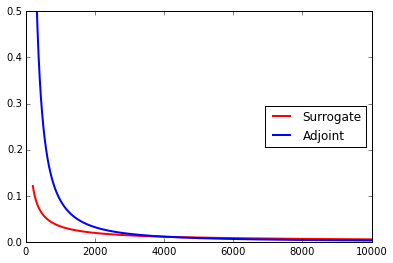

In [9]:
# Plot the error of the two methods
tmin = 2.0 * TJ
tmax = 100 * TJ

f0 = plt.figure(0)
f0.clf()
a0 = f0.add_axes([.1, .1, .8, .8])
t = sp.linspace(tmin, tmax, 10000)

#Plot the values of Eavi Eadj
esur = Esur(t)
eadj = Eadj(t)

a0.plot(t, esur, color='red', linewidth=2.0, label='Surrogate')
a0.plot(t, eadj, color='blue', linewidth=2.0, label='Adjoint')
a0.set_ybound(0.0, 100)
a0.legend(loc='right')
a0.set_ybound((0.0, 0.5))

## OK, so when do we switch methods?

We need to choose a value for the error $E(t)$ where the adjoint method will give faster decrease in error.  That is, for two different times the error value $E_{adj}(t_{adj}) = E_{sur}(t_{sur})$ with their derivatives also equal, 

$\frac{\partial E_{adj}(t_{adj})}{\partial t} = \frac{\partial E_{sur}(t_{sur})}{\partial t}.$

The value of the error here is a good choice for switching to the adjoint method.  Since for error less than that the adjoint method should have a faster decrease in error over time.


<dEsur/dt> = -1.181544912e-05
<dEadj/dt> = -0.000101752208945


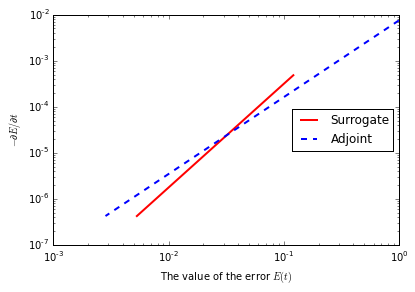

In [10]:
# Derivatives
desur = (esur[1:]- esur[:-1]) / (t[1:]-t[:-1])
deadj = (eadj[1:]- eadj[:-1]) / (t[1:]-t[:-1])
tmid = (t[1:] + t[:-1]) / 2.0
esurmid = (esur[1:] + esur[:-1]) / 2.0
eadjmid = (eadj[1:] + eadj[:-1]) / 2.0

print("<dEsur/dt> = {0}".format(desur.mean()))
print("<dEadj/dt> = {0}".format(deadj.mean()))

f1 = plt.figure(1)
f1.clf()
a1 = f1.add_axes([.1, .1, .8, .8])
a1.loglog(esurmid, -desur, color='red', linewidth=2.0, label='Surrogate')
a1.loglog(eadjmid, -deadj, color='blue', linewidth=2.0, linestyle='--',label='Adjoint')
#a1.set_ybound((-1e0, 0.0))
#a1.set_xbound((esurmid.min(), esurmid.max()))
#a1.set_ybound((-1e-3, 0.0))
a1.set_ylabel(r"$-\partial E / \partial t$")
a1.set_xlabel(r"The value of the error $E(t)$")
a1.legend(loc='right')